# Overview

Analyzing attributes that apply to all r/popular threads collected.

In [68]:
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import datetime as dt
from pymongo import MongoClient
from dotenv import load_dotenv
from tqdm import tqdm
import time
import os
import praw

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

load_dotenv()

reddit = praw.Reddit(
    client_id=os.environ.get('REDDIT_CLIENT_ID_2'),
    client_secret=os.environ.get('REDDIT_CLIENT_SECRET_2'),
    user_agent=os.environ.get('REDDIT_USER_AGENT_2'),
    username=os.environ.get('REDDIT_USERNAME_2'),
    password=os.environ.get('REDDIT_PASSWORD_2')
)

os.chdir('/shared/jackie/resilient-communities/')

client = MongoClient('localhost', 27017)
all_comments = client.resilient.all
popular_snapshots = client.resilient.popular
ps_comments = client.pushshift_comments
ps_threads = client.pushshift_threads

# Data

## Snapshot Features

For each r/popular thread, we have these properties.

1. `id [object]`: The thread ID associated with the thread. To navigate to the thread, go to `reddit.com/id`.
1. `subreddit [object]`: The subreddit the came from.
1. `title [object]`: The title associated with the thread.
1. `domain [object]`: The domain of the link associated with the thread. If there's no link (i.e., it's a text/self thread), then it'll just be a link to Reddit (`redd.it`).
1. `is_self [boolean]`: Whether the thread contains just text (`true`) or is linked to another piece of content (`false`).
1. `selftext [object]`: If it's a self thread, then the text content in the thread.
1. `author [object]`: The author of the thread.
1. `is_video [boolean]`: Whether the thread is video content.
1. `num_snapshots`: The number of snapshots our collection system captured of the thread on r/popular.
1. `max_utc [int]`: The UTC timestamp of the last snapshot.
1. `min_utc [int]`: The UTC timestamp of the first snapshot.
1. `max_rank [int]`: The highest rank the thread had on r/popular. The `0` rank means it was on the top of r/popular.
1. `mean_rank [float]`: Averaged across all snapshots, the mean rank.
1. `max_score [int]`: The maximum score associated with thread.
1. `mean_score [float]`: Averaged across all snapshots, the mean score.
1. `max_upvote_ratio [float]`: The percentage of upvotes compared to downvotes a thread received, e.g., `0.85` means 85% of the votes were upvotes.
1. `mean_upvote_ratio [float]`: Averaged across all snapshots, the mean upvote ratio.
1. `snapshots [object]`: A list of snapshots associated with thread in chronological order.
1. `created_to_popular [int]`: The number of seconds to reach r/popular, i.e., the number of seconds between `created_utc` and `min_utc`.
1. `popular_window [int]`: The number of seconds the thread lasted on r/popular, i.e., the number of seconds between `max_utc` and `min_utc`.

In [13]:
def get_popular_threads(subreddits=None, before=None):

    pipeline = [
        {'$sort': {'retrieved_utc': 1}},
        {'$group': {
            '_id': '$id',
            'subreddit': {'$first': '$subreddit'},
            'created_utc': {'$first': '$created_utc'},
            'title': {'$first': '$title'},
            'domain': {'$first': '$domain'},
            'is_self': {'$first': '$is_self'},
            'author': {'$first': '$author'},
            'selftext': {'$first': '$selftext'},
            'is_video': {'$first': '$is_video'},
            'num_snapshots': {'$sum': 1},
            'max_utc': {'$max': '$retrieved_utc'},
            'min_utc': {'$min': '$retrieved_utc'},
            'max_rank': {'$min': '$rank'},
            'mean_rank': {'$avg': '$rank'},
            'max_score': {'$max': '$score'},
            'mean_score': {'$avg': '$score'},
            'max_upvote_ratio': {'$max': '$upvote_ratio'},
            'mean_upvote_ratio': {'$avg': '$upvote_ratio'},
            'snapshots': {
                '$push': {
                    'retrieved_utc': '$retrieved_utc',
                    'rank': '$rank',
                    'score': '$score',
                    'upvote_ratio': '$upvote_ratio',
                    'num_comments': '$num_comments'
                }
            }
        }},
        {'$sort': {'created_utc': -1}}
    ]

    # Filtering r/popular threads collected too recently.
    if before is not None:
        pipeline = [{'$match': {'created_utc': {'$lte': before}}}] + pipeline

    # Filtering by subreddit.
    if subreddits is not None:
        pipeline = [{'$match': {'subreddit': {'$in': subreddits}}}] + pipeline

    popular_threads = pd.DataFrame(
        popular_snapshots.aggregate(pipeline, allowDiskUse=True)
    ).rename(columns={'_id': 'id'}).set_index('id')

    # Converting UTC to datetime objects.
    for column in ['created_utc', 'max_utc', 'min_utc']:
        new_column = column.split('_')[0] + '_datetime'

        popular_threads[new_column] = \
            pd.to_datetime(popular_threads[column], unit='s') \
            .dt.tz_localize('UTC') \
            .dt.tz_convert('US/Central')

    popular_threads['created_to_popular'] = popular_threads['min_utc'] - \
        popular_threads['created_utc']

    popular_threads['popular_window'] = popular_threads['max_utc'] - \
        popular_threads['min_utc']
    
    popular_threads = popular_threads.astype({
        'created_utc': 'int',
        'created_to_popular': 'int'
    })

    return popular_threads


popular_threads = get_popular_threads()
popular_threads[['subreddit', 'created_utc', 'title', 'author','num_snapshots']]

,subreddit,created_utc,title,author,num_snapshots
id,,,,,
ue3kzd,interestingasfuck,1651175502,"After the 1996 Port Arthur massacre, the Austr...",Consistent-Gap-7120,4
ue2w3x,WatchPeopleDieInside,1651173631,Check out this sweet move,luisquin,28
ue2lxd,teenagers,1651172850,Congratulations s,Immafuckinbitch____,16
ue2k0z,economy,1651172713,"Explain why cancelling $1,900,000,000,000 in s...",failed_evolution,36
ue1wj3,memes,1651170976,My support is for the last one,TWD1fan,16
...,...,...,...,...,...
tkpwlc,AskReddit,1648026929,You are gifted unlimited french fries but are ...,TreeBearOne,6
tkpqgp,PS5,1648026152,System software features like Open and Closed ...,hybroid,16
tkpcb4,IdiotsInCars,1648024281,Speeding in a truck through must/fog,Tyronne43,49


## Subreddit Features

For each subreddit we see in the r/popular thread dataset.

1. `num_moderators [int]`: The number of moderators in the subreddit.
1. `num_subscribers [int]`: The number of subscribers in the subreddit.

In [38]:
def get_subreddit_features(subreddits):

    data = pd.DataFrame(
        index=subreddits,
        columns=['num_moderators', 'num_subscribers']
    )

    for subreddit in tqdm(subreddits):
        subreddit = reddit.subreddit(subreddit)

        data.loc[subreddit.display_name] = {
            'num_moderators': len(list(subreddit.moderator())),
            'num_subscribers': int(subreddit.subscribers)
        }

    return data


subreddit_features = get_subreddit_features(
    popular_threads['subreddit'].unique()
)
subreddit_features

100%|██████████| 692/692 [21:53<00:00,  1.90s/it]


In [48]:
def get_fullnames(thread_ids):
    return ['t3_' + thread_id for thread_id in thread_ids]


def get_comment_features(thread_ids):

    fullnames = get_fullnames(thread_ids)

    pipeline = [
        {'$match': {'link_id': {'$in': fullnames}}},
        {'$project': {
            '_id': 1,
            'id': 1,
            'link_id': 1,
            'created_utc': 1,
            'author': 1
        }},
        {'$group': {
            '_id': '$link_id',
            'authors': {'$addToSet': '$author'},
            'comment_ids': {'$push': '$id'},
            'num_comments': {'$sum': 1},
            'first_utc': {'$min': '$created_utc'},
            'last_utc': {'$max': '$created_utc'}
        }}
    ]

    comment_features = pd.DataFrame(
        all_comments.aggregate(pipeline, allowDiskUse=True)
    ).rename(columns={'_id': 'id'}).set_index('id')

    comment_features.index = comment_features.index.str[3:]

    comment_features['active_window'] = \
        comment_features['last_utc'] - comment_features['first_utc']

    comment_features['num_authors'] = comment_features['authors'].str.len()

    comment_features = comment_features.astype({
        'first_utc': 'int',
        'last_utc': 'int',
        'active_window': 'int'
    })

    return comment_features


comment_features = get_comment_features(popular_threads.index)
comment_features

,authors,comment_ids,num_comments,first_utc,last_utc,active_window,num_authors
id,,,,,,,
rw8i7w,"[caIImebigpoppa, Ahriman27, Legeto, Independen...","[i2w7pkm, i2w83kx, i2w8iih, i2w8llu, i2wb22o, ...",246,1648758497,1649820064,1061567,197
t4btt4,"[geekolojust, mrmaxstacker, MrM3mesYT, Mission...","[i1uzq4j, i1vag6e, i1vgj15, i1vhpay, i1vjh2v, ...",43,1648076556,1648532882,456326,32
t9j7iu,"[ohK7eiN3m, nch2004, Stemen_935, Shoggoththe12...","[i1v0tcd, i1v71n2, i1vbau5, i1vug09, i1vugky, ...",42,1648077016,1648939178,862162,37
temjc9,"[julianhache, Karika3323, DethMagnetic, Inappr...","[i3qwpzm, i3qya8r, i3qyq5k, i3qzovh, i3r0ttn, ...",64,1649328921,1650476757,1147836,58
tkp29x,"[DiddlyDanq, Mystic-Alex, TockSickTauros, push...","[i1v1a1q, i1v1gng, i1v2dr2, i1v3h7k, i1v3kzv, ...",182,1648077212,1651150621,3073409,147
...,...,...,...,...,...,...,...
ue1wj3,"[haveacratay, Savahoodie, bubbleSpiker, Old-Ba...","[i6ke205, i6kelmt, i6kfset, i6kggmk, i6kgrk6, ...",596,1651171136,1651186092,14956,525
ue2k0z,"[Fireemotions, SinningStromgald, _80hd_, bmrig...","[i6kiicz, i6kjjld, i6kk03a, i6kkr3f, i6kl60w, ...",3330,1651172930,1651186094,13164,1930
ue2lxd,"[Demogorgon02, KittenTheSecond, Neolpalm, Past...","[i6kidsp, i6kiect, i6kig6q, i6kigu7, i6kikr5, ...",2804,1651172881,1651186093,13212,2603


# Visualizations

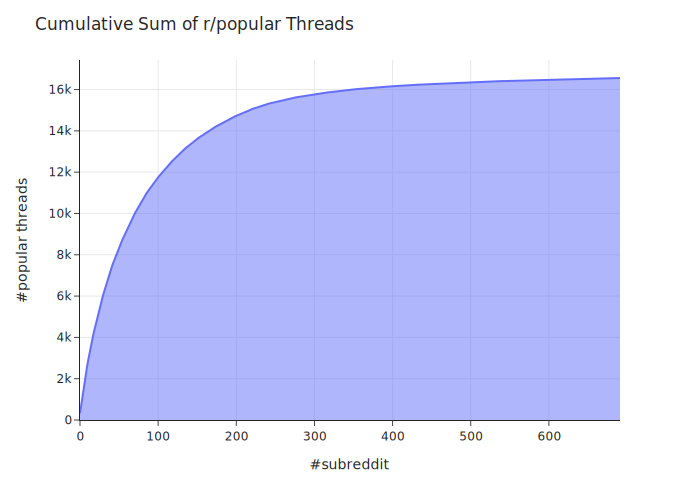

In [92]:
def display_cumulative_sum():

    data = popular_threads['subreddit'] \
        .value_counts() \
        .cumsum() \
        .reset_index()['subreddit']

    fig = px.area(data)

    fig.update_layout(
        template='simple_white',
        showlegend=False,
        xaxis_title='#subreddit',
        yaxis_title='#popular threads',
        title='Cumulative Sum of r/popular Threads'
    )

    fig.update_xaxes(
        showgrid=True
    )

    fig.update_yaxes(
        showgrid=True
    )

    return fig


fig = display_cumulative_sum()
fig.show('svg')